<a href="https://colab.research.google.com/github/andersenthomas98/timeseries-forecasting/blob/main/Lag_Llama_Fine_Tuning_Daily_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning lag-llama using daily climate dataset


Clone lag-llama github repository

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 178 (delta 52), reused 59 (delta 42), pack-reused 99
Receiving objects: 100% (178/178), 201.23 KiB | 2.72 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


Install python dependencies

In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 62.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

Download pretrained model weights

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpmcoo223o
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 139MB/s] 
/content/lag-llama/lag-llama.ckpt


Add imports

In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from gluonts.dataset.pandas import PandasDataset
import pandas as pd
from numpy import nan

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-5-9ee5475835bf>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Create a prediction function

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

Download daily climate dataset from kaggle

In [7]:
!pip install kaggle

In [9]:
from google.colab import userdata
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Setup environment variables for authenticating to kaggle using the kaggle API
kaggleUsername = userdata.get("KAGGLE_USERNAME")
kaggleKey = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = kaggleUsername
os.environ["KAGGLE_KEY"] = kaggleKey

# Authenticate
api = KaggleApi()
api.authenticate()

# Download dataset
datasetName = "sumanthvrao/daily-climate-time-series-data"
datasetPath = "/content/climate"
api.dataset_download_files(datasetName, path=datasetPath, unzip=True)

             meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666687
2013-01-02   7.400000   92.000000    2.980000   1017.799988
2013-01-03   7.166667   87.000000    4.633333   1018.666687
2013-01-04   8.666667   71.333336    1.233333   1017.166687
2013-01-05   6.000000   86.833336    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217392   68.043480    3.547826   1015.565247
2016-12-29  15.238095   87.857140    6.000000   1016.904785
2016-12-30  14.095238   89.666664    6.266667   1017.904785
2016-12-31  15.052631   87.000000    7.325000   1016.099976
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]
meantemp        float32
humidity        float32
wind_speed      float32
meanpressure    float32
dtype: object
datetime64[ns]
First date: 2013-01-01 00:00:00
Last date: 2017-01-01 00:00:00


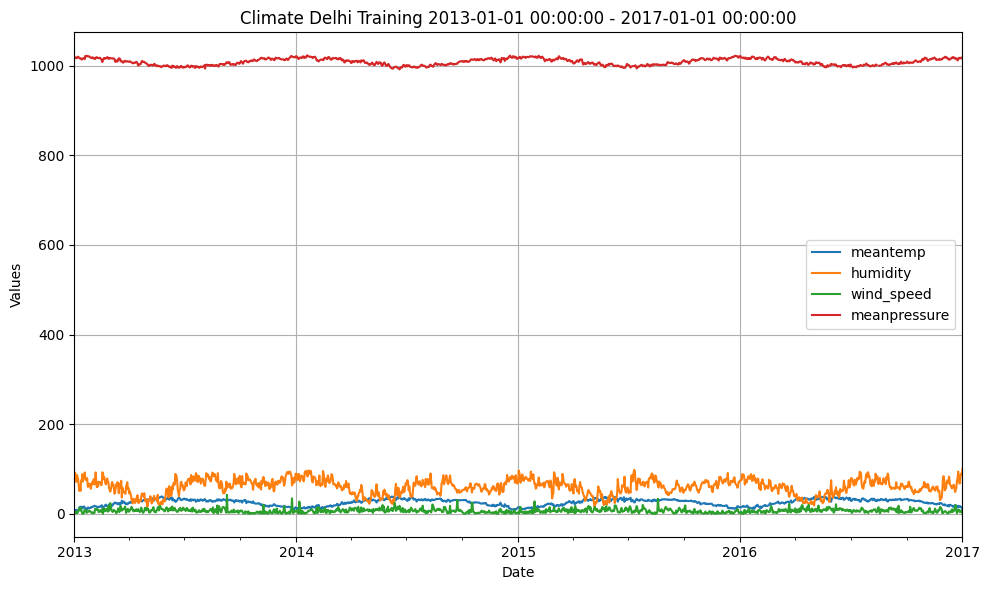

In [10]:
filePathTrain = "{}/DailyDelhiClimateTrain.csv".format(datasetPath)
df = pd.read_csv(filePathTrain, index_col=0, parse_dates=True)

for col in df.columns:
  if df[col].dtype != "object" and pd.api.types.is_string_dtype(df[col]) == False:
    df[col] = df[col].astype("float32")

# meanpressure column has large outliers
filterColumnName = "meanpressure"

Q1 = df[filterColumnName].quantile(0.25)
Q3 = df[filterColumnName].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what's considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
df[filterColumnName] = df[filterColumnName].mask((df[filterColumnName] < lower_bound) | (df[filterColumnName] > upper_bound), nan)

print(df)
print(df.dtypes)
print(df.index.dtype)

# Get the first date
first_date = df.index.min()
print(f"First date: {first_date}")

# Get the last date
last_date = df.index.max()
print(f"Last date: {last_date}")

# Plotting all series in the DataFrame
df.plot(figsize=(10, 6))  # You can adjust the size with 'figsize'

# Customize the plot with titles, labels, etc.
plt.title('Climate Delhi Training {} - {}'.format(first_date, last_date))
plt.xlabel('Date')  # The label for the x-axis, which is the date here
plt.ylabel('Values')  # The label for the y-axis, which could be adjusted to fit your data
plt.legend()
plt.grid(True)  # Adds a grid for easier readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area

# Show the plot
plt.show()

In [11]:
# Create a PandasDataset
ds_train = PandasDataset(dict(df))

Define the lag-llama estimator and its hyperparameters

In [30]:
deviceType="cuda"
ckpt = torch.load("lag-llama.ckpt", map_location=deviceType)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

prediction_length = 30
context_length = prediction_length*3
num_samples = 20

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
        device=torch.device(deviceType)
    )

Fine-tune the lag-llama base model on the daily climate dataset

In [31]:
predictor = estimator.train(ds_train, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentat

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 4.44989 (best 4.44989), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 4.44989 (best 4.44989), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 3.50774 (best 3.50774), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 3.50774 (best 3.50774), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 3.44947 (best 3.44947), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

/content/climate/DailyDelhiClimateTest.csv
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
2017-01-06  19.318182  79.318182    8.681818   1011.772727
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900000  40.900000    8.890000   1001.600000
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142857

[113 rows x 4 columns]
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object
datetime64[ns]
First date: 2017-01-02 00:00:00
Last date

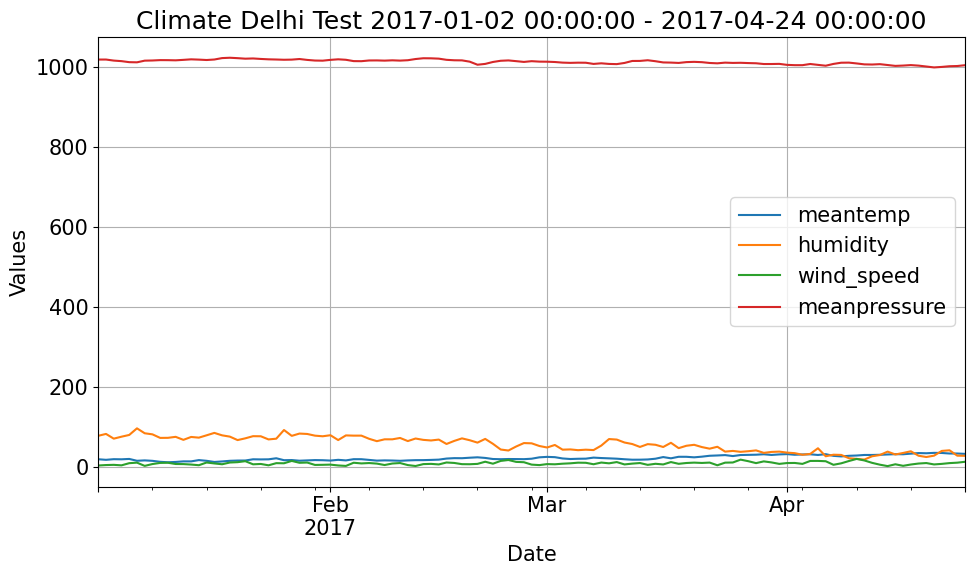

In [32]:
filePathTest = "{}/DailyDelhiClimateTest.csv".format(datasetPath)
print(filePathTest)
df = pd.read_csv(filePathTest, index_col=0, parse_dates=True)

# Remove first row as it contains in-accurate data for mean pressure
df = df.iloc[1:]

print(df)
print(df.dtypes)
print(df.index.dtype)

# Ensure all numerical columns are float32
for col in df.columns:
  if df[col].dtype != "object" and pd.api.types.is_string_dtype(df[col]) == False:
    df[col] = df[col].astype("float32")

# Get the first date
first_date = df.index.min()
print(f"First date: {first_date}")

# Get the last date
last_date = df.index.max()
print(f"Last date: {last_date}")

# Plotting all series in the DataFrame
df.plot(figsize=(10, 6))  # You can adjust the size with 'figsize'

# Customize the plot with titles, labels, etc.
plt.title('Climate Delhi Test {} - {}'.format(first_date, last_date))
plt.xlabel('Date')  # The label for the x-axis, which is the date here
plt.ylabel('Values')  # The label for the y-axis, which could be adjusted to fit your data
plt.legend()
plt.grid(True)  # Adds a grid for easier readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area

# Show the plot
plt.show()

ds_test = PandasDataset(dict(df))

In [33]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds_test,
        predictor=predictor,
        num_samples=num_samples
    )

In [34]:
forecasts = list(tqdm(forecast_it, total=len(ds_test), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
print(len(forecasts))

4


In [36]:
tss = list(tqdm(ts_it, total=len(ds_test), desc="Ground truth"))

Ground truth:   0%|          | 0/4 [00:00<?, ?it/s]

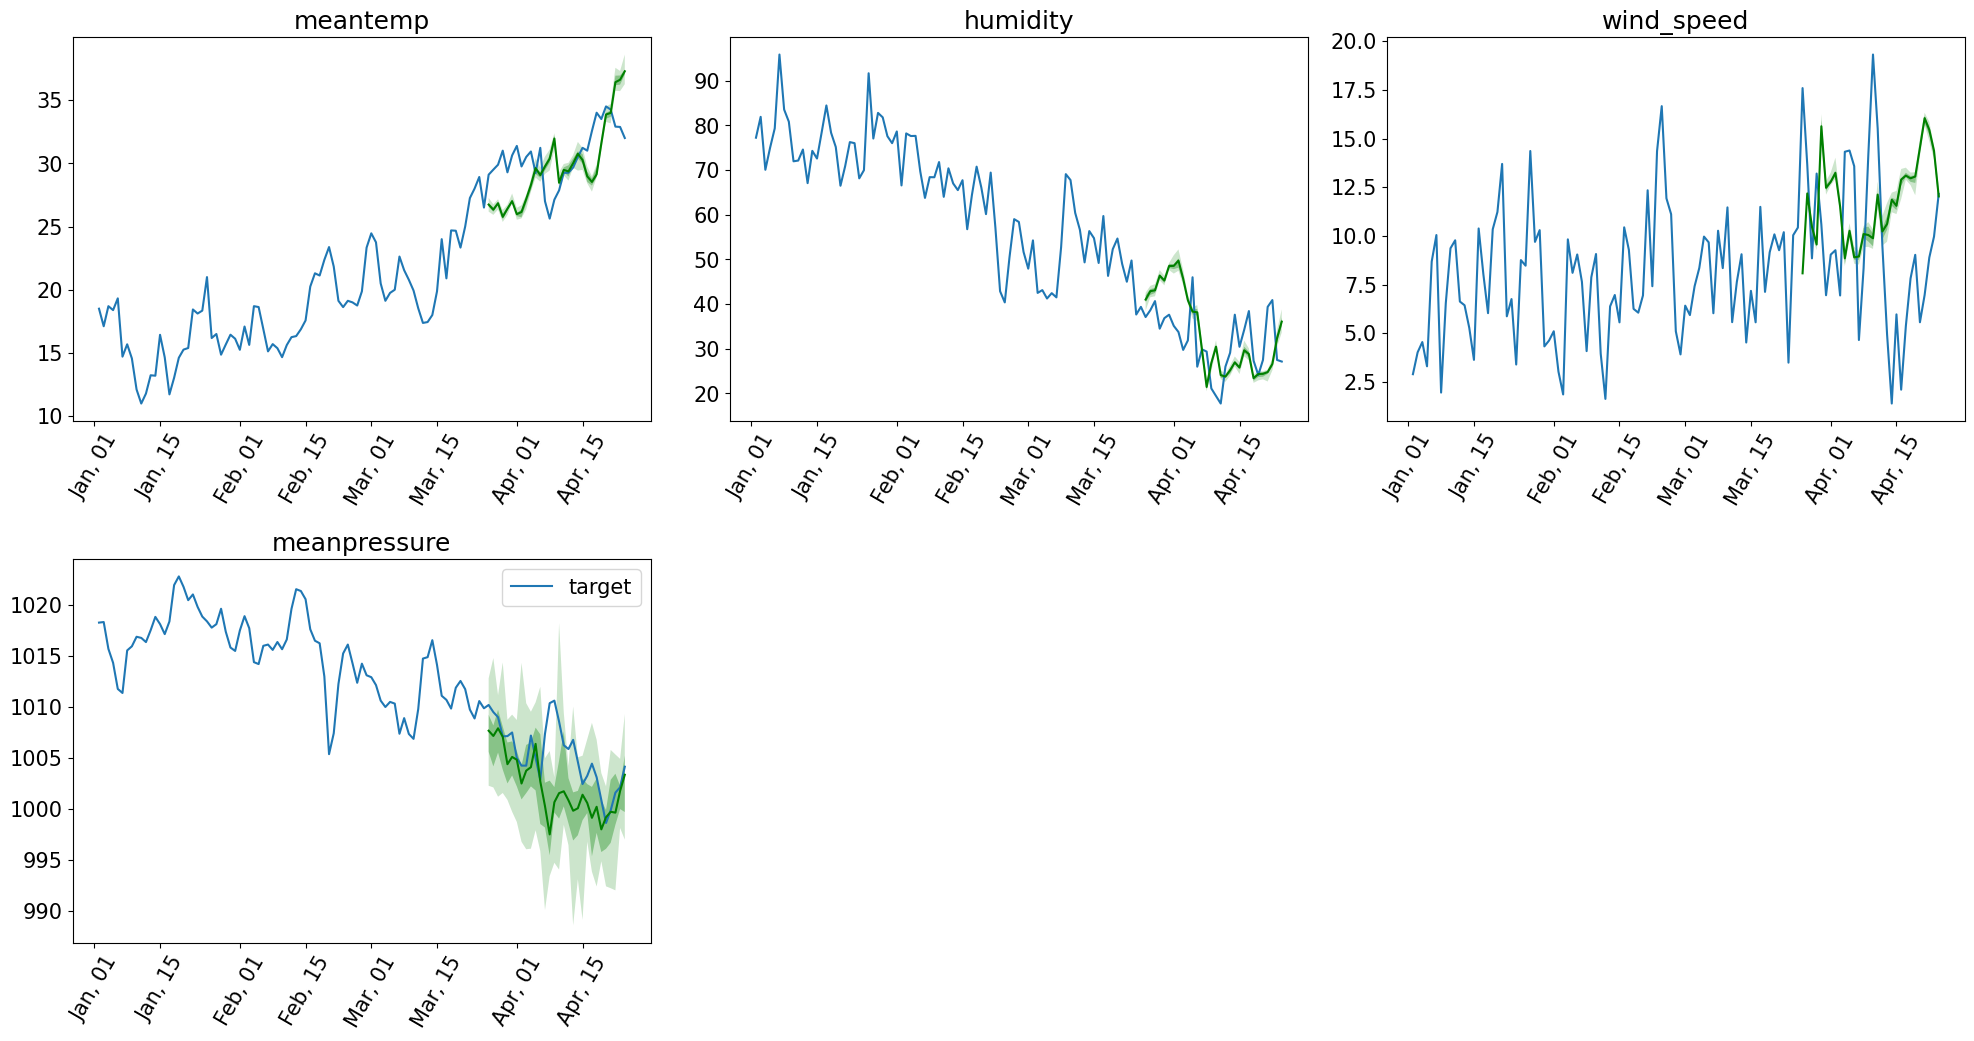

In [37]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 4 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [38]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 4it [00:00, 99.97it/s]


In [39]:
agg_metrics

{'MSE': 35.784097798665364,
 'abs_error': 562.0006256103516,
 'abs_target_sum': 32322.58413696289,
 'abs_target_mean': 269.3548678080241,
 'seasonal_error': 2.959926419141816,
 'MASE': 1.779621366693477,
 'MAPE': 0.3220745273555318,
 'sMAPE': 0.21050219095001618,
 'MSIS': 45.08946253248662,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 536.2368487358094,
 'Coverage[0.1]': 0.3583333333333333,
 'QuantileLoss[0.2]': 567.2025077819825,
 'Coverage[0.2]': 0.3666666666666667,
 'QuantileLoss[0.3]': 581.415515613556,
 'Coverage[0.3]': 0.3833333333333333,
 'QuantileLoss[0.4]': 578.3869775772094,
 'Coverage[0.4]': 0.39999999999999997,
 'QuantileLoss[0.5]': 562.0006241798401,
 'Coverage[0.5]': 0.425,
 'QuantileLoss[0.6]': 545.6191104888916,
 'Coverage[0.6]': 0.475,
 'QuantileLoss[0.7]': 505.9652474403381,
 'Coverage[0.7]': 0.525,
 'QuantileLoss[0.8]': 464.22263317108155,
 'Coverage[0.8]': 0.6,
 'QuantileLoss[0.9]': 412.4275067329406,
 'Coverage[0.9]': 0.625,
 'RMSE': 5.9819810931384065,
